In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np
import lime
import lime.lime_tabular
from sklearn.model_selection import cross_val_score
import pickle

In [2]:
# Load the dataset
dataset = pd.read_csv('dataset_churn.csv')

In [3]:
# Preview the dataset
dataset.head()

,Unnamed: 0,CustomerID,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn
0,0,08729464-bde6-43bc-8f63-a357096feab1,56.0,Male,13,DSL,Yes,No,One year,Mailed check,71.88,931.49,No,No,Yes,No,No
1,1,af95bc95-baf4-4318-a21d-70d2ea3148b7,69.0,Male,13,DSL,No,Yes,Two year,Mailed check,110.99,1448.46,Yes,Yes,No,No,No
2,2,1fe7eee6-2227-4400-9998-4d993f4a60fd,46.0,Male,60,Fiber optic,No,Yes,Month-to-month,Mailed check,116.74,6997.73,Yes,Yes,No,No,No
3,3,f736fe7b-1b44-4acd-84c2-21c4aef648be,32.0,Female,57,Fiber optic,Yes,Yes,Month-to-month,Bank transfer,78.16,4452.13,No,Yes,No,Yes,No
4,4,4b40d12d-7633-4309-96b8-aee675ea20ae,60.0,Male,52,Fiber optic,Yes,Yes,Two year,Electronic check,30.33,1569.73,Yes,No,Yes,Yes,No


In [5]:
# Strip any leading/trailing spaces from the column names
dataset.columns = dataset.columns.str.strip()

# Remove unnecessary columns
dataset = dataset.drop(columns = ['Unnamed: 0', 'CustomerID'])

# Check the dataset after removing unnecessary columns
dataset.head()

,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn
0,56.0,Male,13,DSL,Yes,No,One year,Mailed check,71.88,931.49,No,No,Yes,No,No
1,69.0,Male,13,DSL,No,Yes,Two year,Mailed check,110.99,1448.46,Yes,Yes,No,No,No
2,46.0,Male,60,Fiber optic,No,Yes,Month-to-month,Mailed check,116.74,6997.73,Yes,Yes,No,No,No
3,32.0,Female,57,Fiber optic,Yes,Yes,Month-to-month,Bank transfer,78.16,4452.13,No,Yes,No,Yes,No
4,60.0,Male,52,Fiber optic,Yes,Yes,Two year,Electronic check,30.33,1569.73,Yes,No,Yes,Yes,No


In [6]:
# Check the dataset shape and describe the data
print(f"Dataset shape: {dataset.shape}")
print(dataset.describe())

Dataset shape: (3749, 15)
               Age       Tenure  MonthlyCharges  TotalCharges
count  3562.000000  3749.000000     3749.000000   3749.000000
mean     43.655531    36.264070       75.844318   2718.968266
std      14.914474    20.505528       73.062971   3211.879149
min      18.000000     1.000000       20.000000     13.190000
25%      31.000000    19.000000       44.570000   1076.240000
50%      44.000000    36.000000       69.590000   2132.260000
75%      56.000000    54.000000       95.540000   3619.710000
max      69.000000    71.000000     1179.300000  79951.800000


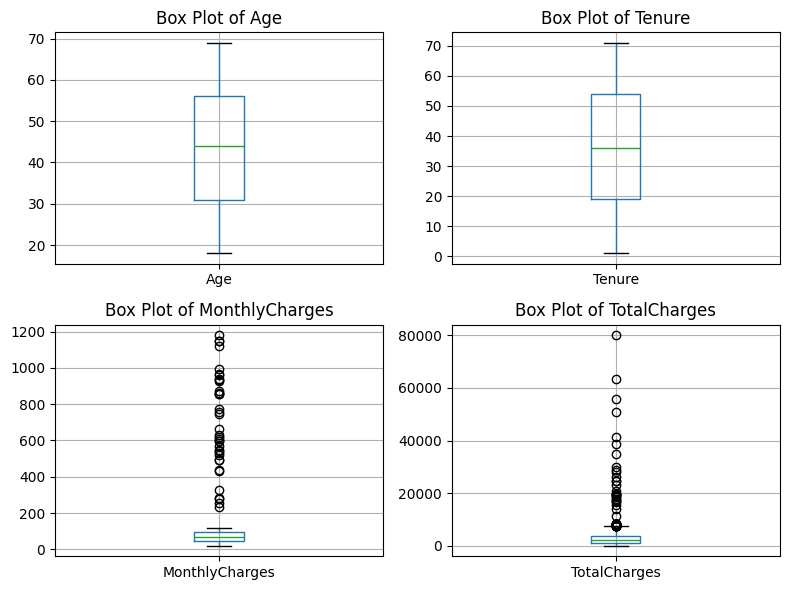

In [10]:
# Visualizing numerical features with box plots
numerical_columns = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize = (8,6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    dataset.boxplot(column = column)
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

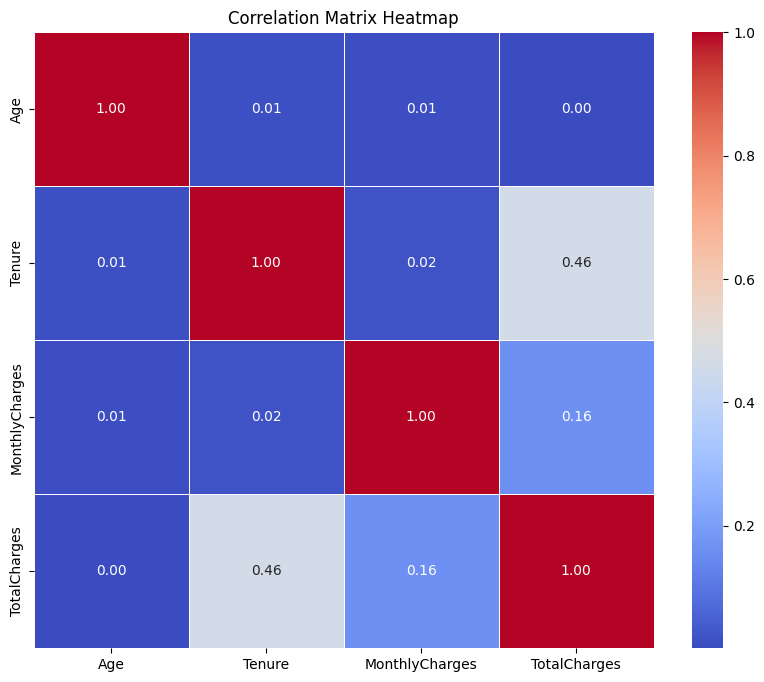

In [11]:
# Correlation Matrix
correlation_matrix = dataset[numerical_columns].corr()

# Plotting the correlation matrix heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidth = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [12]:
# Check for the missing values
dataset.isnull().sum()

Age                 187
Gender                0
Tenure                0
Service_Internet    721
Service_Phone         0
Service_TV            0
Contract              0
PaymentMethod       187
MonthlyCharges        0
TotalCharges          0
StreamingMovies       0
StreamingMusic        0
OnlineSecurity        0
TechSupport           0
Churn                 0
dtype: int64

In [13]:
# Handle missing values using median for numeric columns and mode for categorical columns
imputer_median = SimpleImputer(strategy = 'median')
dataset['Age'] = imputer_median.fit_transform(dataset[['Age']]).ravel()

imputer_mode = SimpleImputer(strategy = 'most_frequent')
dataset['PaymentMethod'] = imputer_mode.fit_transform(dataset[['PaymentMethod']]).ravel()
dataset['Service_Internet'] = imputer_mode.fit_transform(dataset[['Service_Internet']]).ravel()

In [14]:
# Check for remaining missing values
dataset.isnull().sum()

Age                 0
Gender              0
Tenure              0
Service_Internet    0
Service_Phone       0
Service_TV          0
Contract            0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
StreamingMovies     0
StreamingMusic      0
OnlineSecurity      0
TechSupport         0
Churn               0
dtype: int64

In [15]:
# Label encode categorical columns
categorical_features = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV',
                         'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic',
                         'OnlineSecurity', 'TechSupport', 'Churn']

labelencoder = LabelEncoder()
dataset[categorical_features] = dataset[categorical_features].apply(labelencoder.fit_transform)

In [16]:
# Clipping outliers based on the IQR method
columns_to_clip = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

for column in columns_to_clip:
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dataset[column] = np.clip(dataset[column], lower_bound, upper_bound)

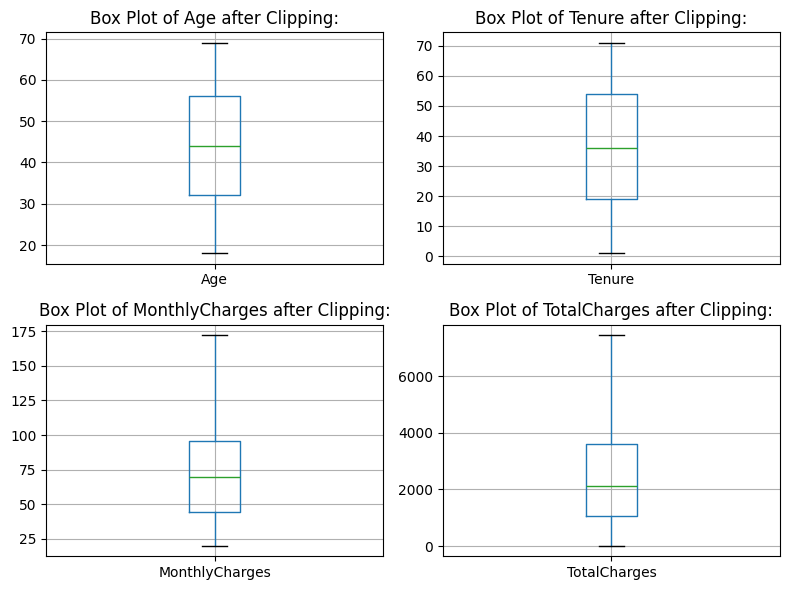

In [17]:
# Visualize the distribution after clipping
plt.figure(figsize = (8,6))
for i, column in enumerate(columns_to_clip, 1):
    plt.subplot(2,2,i)
    dataset.boxplot(column=column)
    plt.title(f'Box Plot of {column} after Clipping:')
plt.tight_layout()
plt.show()

In [18]:
# Cleaned dataset 
cleaned_dataset = dataset.copy()

# Save the modified dataset
cleaned_dataset.to_csv('cleaned_dataset.csv', index = False, sep = ';')

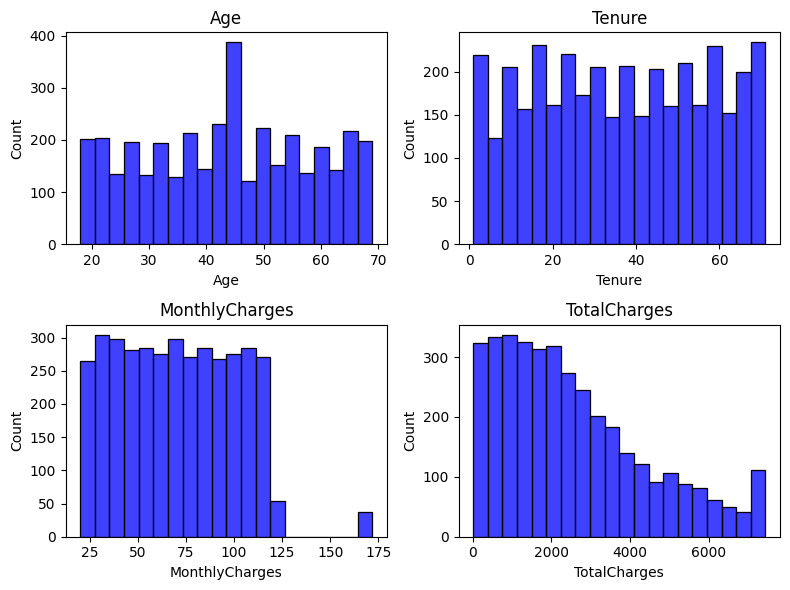

In [19]:
# Visualizing distribution of numerical features with histograms
plt.figure(figsize = (8,6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(dataset[column], bins = 20, color = 'blue')
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

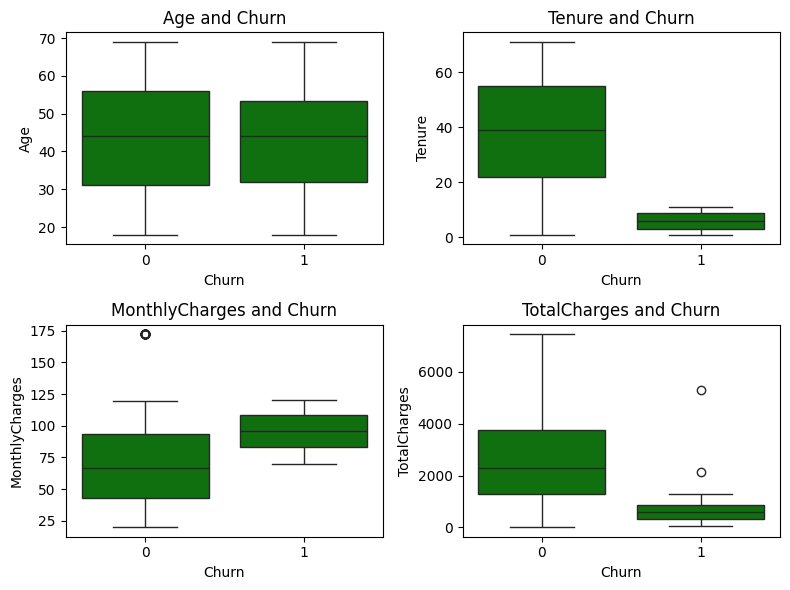

In [20]:
# Box plots for numerical features vs Churn
plt.figure(figsize = (8,6))
for i, col in enumerate(numerical_columns):
    plt.subplot(2,2, i + 1)
    sns.boxplot(x='Churn', y=col, data=dataset, color='green')
    plt.title(f'{col} and Churn')
    plt.tight_layout()

plt.show()

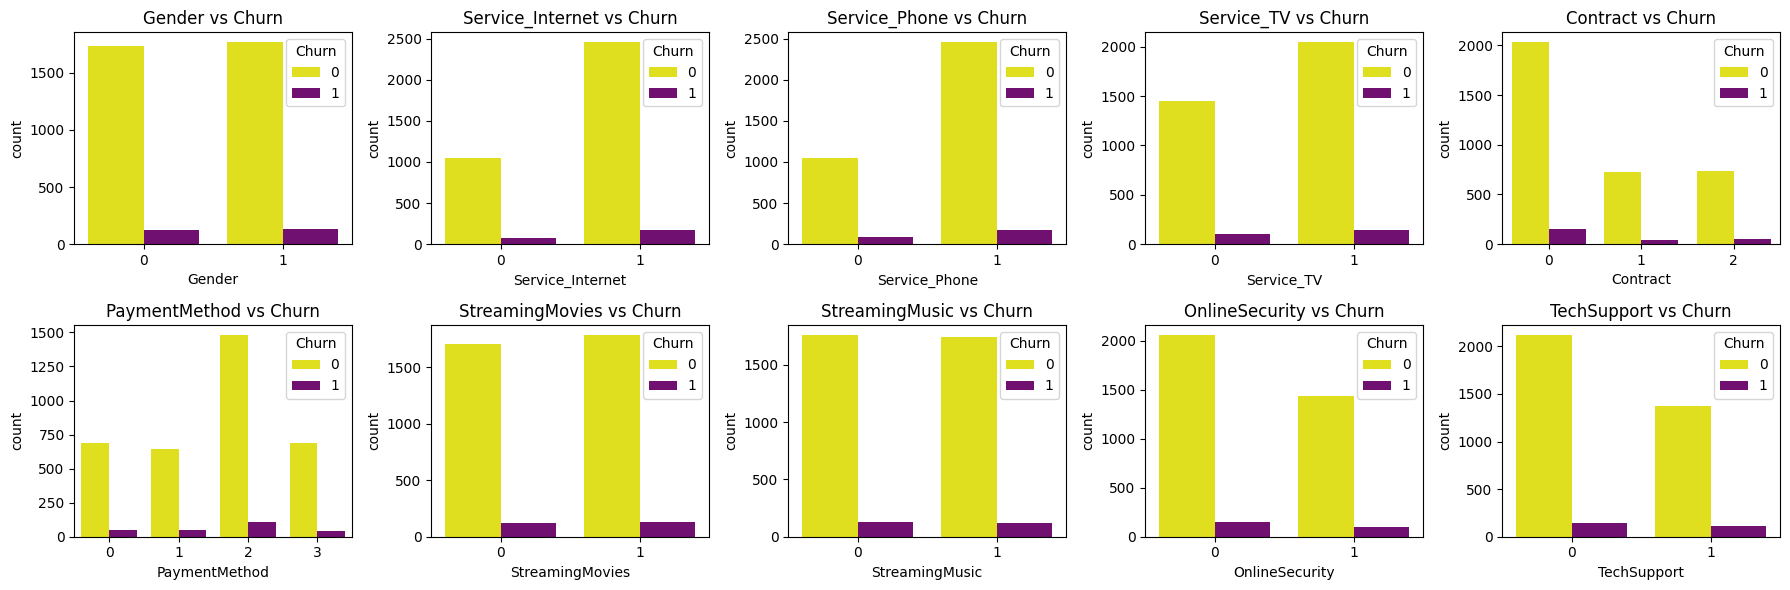

In [22]:
# Count plots for categorical features vs Churn
cats = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV', 'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic', 'OnlineSecurity', 'TechSupport']

plt.figure(figsize=(18,6))
for i, col in enumerate(cats):
    plt.subplot(2, 5, i + 1)
    sns.countplot(x=col, hue='Churn', data=dataset, palette = ['yellow', 'purple'])
    plt.title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

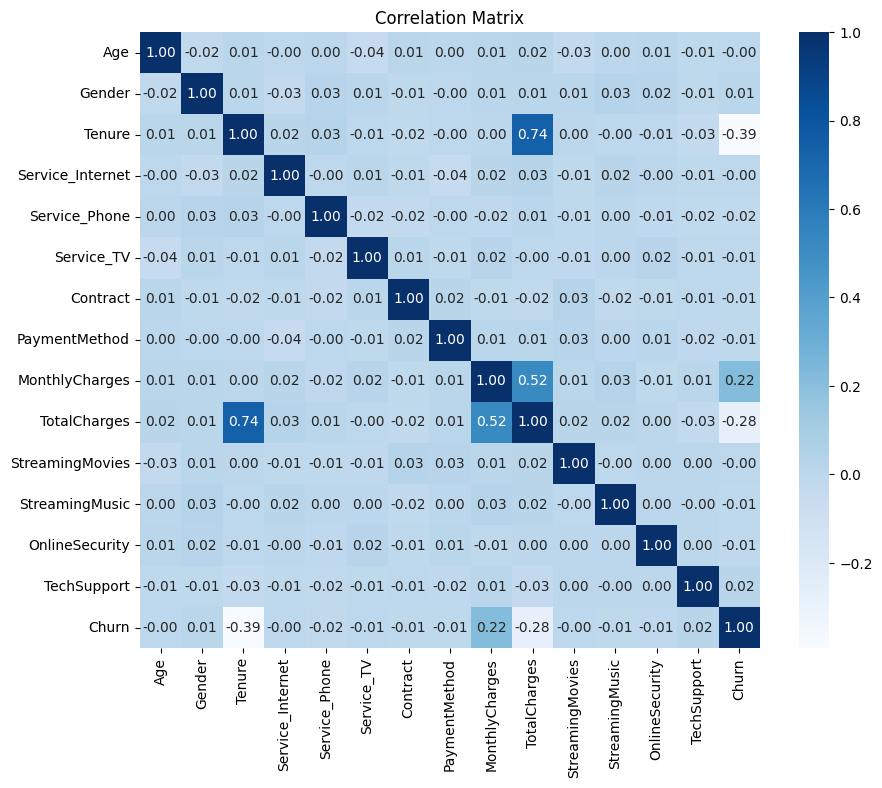

In [23]:
# Correlation heatmap for numerical features
plt.figure(figsize = (10, 8))
sns.heatmap(dataset.corr(), annot = True, cmap = 'Blues', fmt = ".2f")
plt.title('Correlation Matrix')
plt.show()

In [25]:
# Chi-Square test for categorical features
X_categorical = dataset[['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV',
                         'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic',
                         'OnlineSecurity', 'TechSupport']]
Y = dataset["Churn"]

chi_scores, p_values = chi2(X_categorical, Y)

chi_square_results = pd.DataFrame({
    'Feature': X_categorical.columns,
    'Chi-Squre Score': chi_scores,
    'p-value': p_values
}).sort_values(by = 'p-value')

print("Chi-Square Test Results for Categorical Features: ")
print(chi_square_results)

Chi-Square Test Results for Categorical Features: 
            Feature  Chi-Squre Score   p-value
9       TechSupport         0.780247  0.377065
4          Contract         0.534231  0.464834
2     Service_Phone         0.439102  0.507556
8    OnlineSecurity         0.339420  0.560164
5     PaymentMethod         0.229804  0.631669
7    StreamingMusic         0.171462  0.678816
0            Gender         0.082627  0.773768
3        Service_TV         0.045332  0.831394
6   StreamingMovies         0.036121  0.849267
1  Service_Internet         0.024715  0.875080


In [26]:
# Feature Engineering
new_dataset = dataset.copy()
new_dataset['TotalServices'] = (new_dataset['Service_Internet'] + new_dataset['Service_Phone'] + new_dataset['Service_TV'] + new_dataset['OnlineSecurity'] + new_dataset['TechSupport'])
new_dataset['CLV'] = new_dataset['MonthlyCharges'] * new_dataset['Tenure']
new_dataset['AvgMonthlyChargeOverTenure'] = new_dataset['TotalCharges'] / (new_dataset['Tenure'] + 1)
new_dataset['RecentPaymentDrop'] = new_dataset['MonthlyCharges'] / new_dataset['AvgMonthlyChargeOverTenure']

# Save the modified dataset
new_dataset.to_csv('new_dataset.csv', index=False, sep=';')

In [27]:
# Prepare features and target variable 
X = new_dataset.drop('Churn', axis = 1)
Y = new_dataset['Churn']

In [28]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(f'Training Feature Shape: {X_train.shape}')
print(f'Training Feature Shape: {X_test.shape}')

Training Feature Shape: (2999, 18)
Training Feature Shape: (750, 18)


In [30]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Function to train and evauluate models
def train_evaluate_plot(model, model_name, X_train_scaled, X_test_scaled, Y_train, Y_test):
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)

    print(f'{model_name} accuracy: {accuracy_score(Y_test, Y_pred): .4f}')

    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        print(f'{model_name} ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}\n')

    print(classification_report(Y_test, Y_pred))
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot = True, fmt = 'd', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    cv_scores = cross_val_score(model, X_train_scaled, Y_train, cv=5, scoring = 'accuracy')
    print(f'{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Logistic Regression accuracy:  0.9827
Logistic Regression ROC-AUC: 0.9954

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       707
           1       0.86      0.84      0.85        43

    accuracy                           0.98       750
   macro avg       0.92      0.91      0.92       750
weighted avg       0.98      0.98      0.98       750



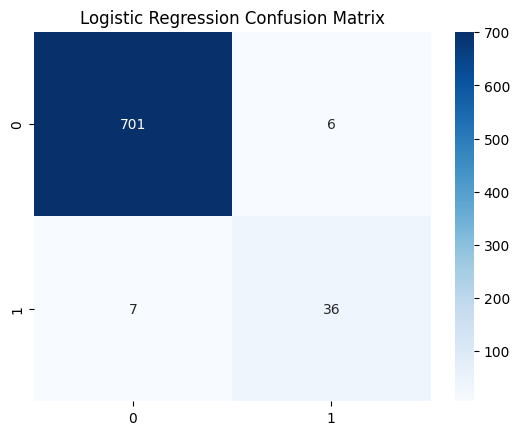

Logistic Regression Cross-Validation Accuracy: 0.9817 ± 0.0046


In [36]:
# Train and evaluate different models
train_evaluate_plot(LogisticRegression(random_state = 42), "Logistic Regression", X_train_scaled, X_test_scaled, Y_train, Y_test)

Decision Tree accuracy:  0.9987
Decision Tree ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



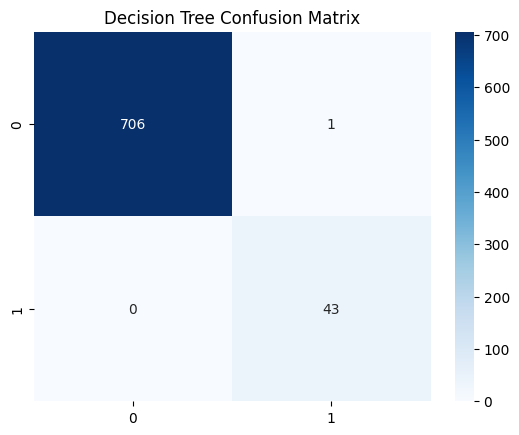

Decision Tree Cross-Validation Accuracy: 0.9990 ± 0.0013


In [37]:
train_evaluate_plot(DecisionTreeClassifier(random_state=42), "Decision Tree", X_train_scaled, X_test_scaled, Y_train, Y_test)

Random Forest accuracy:  0.9987
Random Forest ROC-AUC: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



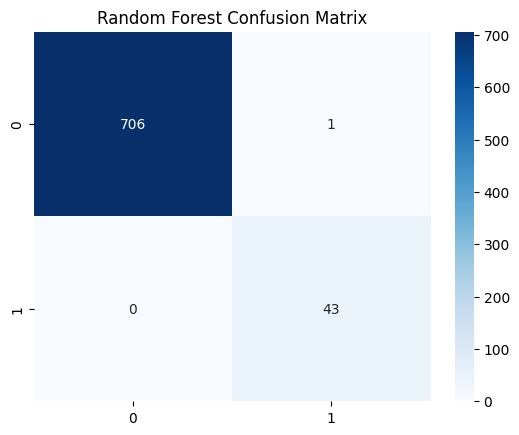

Random Forest Cross-Validation Accuracy: 0.9987 ± 0.0012


In [38]:
train_evaluate_plot(RandomForestClassifier(random_state=42), "Random Forest", X_train_scaled, X_test_scaled, Y_train, Y_test)

Gradient Boosting accuracy:  0.9987
Gradient Boosting ROC-AUC: 0.9993

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.98      1.00      0.99        43

    accuracy                           1.00       750
   macro avg       0.99      1.00      0.99       750
weighted avg       1.00      1.00      1.00       750



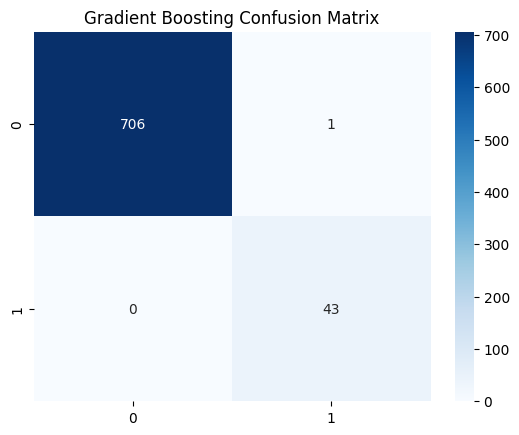

Gradient Boosting Cross-Validation Accuracy: 0.9990 ± 0.0013


In [39]:
train_evaluate_plot(GradientBoostingClassifier(random_state=42), "Gradient Boosting", X_train_scaled, X_test_scaled, Y_train, Y_test)

In [43]:
pickle.dump(LogisticRegression, open("models/logistic_regression.pkl", "wb"))
pickle.dump(DecisionTreeClassifier, open("models/decision_tree.pkl", "wb"))
pickle.dump(RandomForestClassifier, open("models/random_forest.pkl", "wb"))
pickle.dump(GradientBoostingClassifier, open("models/logistic_regression.pkl", "wb"))

In [45]:
# Hyperparameter grids for models
param_grid_logistic = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200]
}

param_grid_decision_tree = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_random_forest = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gradient_boosting = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}